## Ungraded Lab: MNIST Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [11]:
def map_image(image, label):
  """Normalizes and flatten the images. Returns image as input and label."""
  image = tf.cast(image, dtype=tf.float32)
  image /= 255.0
  image = tf.reshape(image, shape=(784,))
  return image, image

In [12]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load("mnist", as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset  = tfds.load("mnist", as_supervised=True, split="test")
test_dataset  = test_dataset.map(map_image)
test_dataset  = test_dataset.batch(BATCH_SIZE).repeat()

## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

In [13]:
def simple_autoencoder(inputs):
  """Builds the encoder and decoder using Dense layers"""
  encoder = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
  decoder = tf.keras.layers.Dense(units=784, activation="sigmoid")(encoder)
  return encoder, decoder

# set the input shape
inputs = tf.keras.layers.Input(shape=(784,))

# get the encoder and decoder ouptut
encoder_output, decoder_output = simple_autoencoder(inputs)

# setup the encoder because you will visualize its output later
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup the autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [14]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy"
)

## Train the Model

In [15]:
train_steps = 60000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset,
                                            steps_per_epoch=train_steps,
                                            epochs=50)

Epoch 1/50
468/468 [==============================] - 16s 27ms/step - loss: 0.2269
Epoch 2/50
468/468 [==============================] - 7s 14ms/step - loss: 0.1413
Epoch 3/50
468/468 [==============================] - 7s 15ms/step - loss: 0.1185
Epoch 4/50
468/468 [==============================] - 6s 14ms/step - loss: 0.1070
Epoch 5/50
468/468 [==============================] - 5s 10ms/step - loss: 0.1007
Epoch 6/50
468/468 [==============================] - 5s 10ms/step - loss: 0.0973
Epoch 7/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0957
Epoch 8/50
468/468 [==============================] - 7s 15ms/step - loss: 0.0949
Epoch 9/50
468/468 [==============================] - 7s 15ms/step - loss: 0.0944
Epoch 10/50
468/468 [==============================] - 7s 15ms/step - loss: 0.0941
Epoch 11/50
468/468 [==============================] - 8s 18ms/step - loss: 0.0939
Epoch 12/50
468/468 [==============================] - 9s 20ms/step - loss: 0.0937
Epoch 13/50


## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [16]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  """Display sample outputs in one row."""
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 4)):
  """Display the input, encoded, and decoded output values."""
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28, 28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28, 28,))

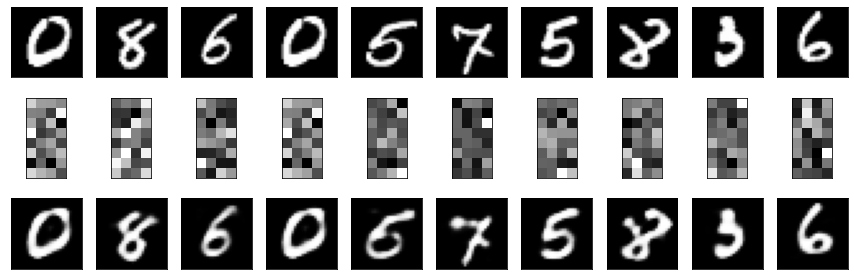

In [17]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])